In [1]:
from icevision.all import *
import os

In [9]:
# specify image directory and annotations filepath
annotations_pth = 'data/annotations_train.json'
filtered_annotations_pth = 'data/annotations_filtered.json'
images_dir = 'data/images'

In [10]:
from PIL import Image
from tqdm import tqdm
# remove images that can not be downloaded or opened
with open(annotations_pth) as f:
    coco = json.load(f)

remove_ids = []

for img in tqdm(coco['images']):
    try:
        Image.open(f'{images_dir}/{img["file_name"]}').load()
    except OSError:
        remove_ids.append(img['id'])

imgs_filtered = [img for img in coco['images'] if img['id'] not in remove_ids]

anns_filtered = [ann for ann in coco['annotations'] if ann['image_id'] not in remove_ids]

print(f'{len(remove_ids)} images could not be loaded. Removing from annotations.')


coco['images'] = imgs_filtered
coco['annotations'] = anns_filtered


with open(filtered_annotations_pth, 'w') as f:
    json.dump(coco,f) 

100%|██████████| 2116/2116 [00:07<00:00, 276.26it/s]


1 images not found. Removing from annotations.


In [11]:
parser = parsers.COCOBBoxParser(annotations_filepath = filtered_annotations_pth, img_dir = images_dir)

In [12]:
# parse annotations
train_records, valid_records = parser.parse()

  0%|          | 0/15482 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/1692 [00:00<?, ?it/s]

  0%|          | 0/423 [00:00<?, ?it/s]

In [13]:
# define image size and transformations, adapt as you like
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=768), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [14]:
# load datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [15]:
# create baseline model
import torch
import torchvision
from icevision import models

# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
model_type = models.torchvision.faster_rcnn
model = model_type.model(num_classes=len(parser.class_map))

model.to(device)

print("Model ready")

Model ready


In [16]:
# Create data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [17]:
# Create fastai learner
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=4.365158383734524e-05)

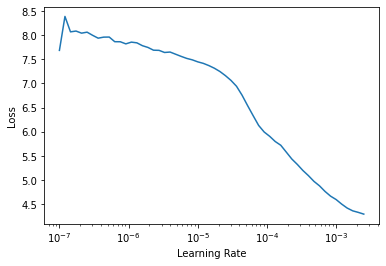

In [18]:
# determine optimal learning rate
learn.lr_find()

In [19]:
# use learning rate from above to start training
# freeze epochs to initially train the head only (empirically gives better results)
lr = 1e-3
learn.fine_tune(1, lr, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,2.033779,1.627415,0.011875,00:42


epoch,train_loss,valid_loss,COCOMetric,time
0,0.998742,0.881373,0.028791,01:03


In [12]:
# continue training 
# repeat any number of times until convergence, possibly adapt (decrease) learning rate
lr = 1e-4
learn.fine_tune(5, lr, freeze_epochs=0)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.467502,0.805629,0.099184,02:31
1,0.473283,0.807095,0.098537,02:32
2,0.487323,0.812551,0.101269,02:32
3,0.465229,0.811590,0.100632,02:32
4,0.463997,0.810149,0.100923,02:33


In [48]:
# save the model
learn.save('baseline_model')

Path('models/baseline_model.pth')